In [5]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Suppress Cartopy download warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cartopy.io')


# — Common styling —
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

# Approximate lon/lat positions for NL, DE, CZ
positions = {
    'NL': (5.5, 52.2),
    'DE': (11.0, 51.2),
    'CZ': (15.5, 49.8),
}

# Core countries to shade in panel 3
acer_core = [
    'Austria','Belgium','Croatia','Czech Republic','France','Germany',
    'Hungary','Luxembourg','Netherlands','Poland','Romania','Slovakia','Slovenia'
]

# Countries to shade in panels 1 & 2
focus_names = ['Netherlands', 'Germany', 'Luxembourg', 'Czech Republic']

reader = shpreader.Reader(
    shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
)

# geometries for the small focus set
geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in focus_names
}

# geometries for the ACER CORE set
core_geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in acer_core
}

def shade_focus(ax):
    """Shade the four focus countries."""
    for geom in geoms.values():
        ax.add_geometries(
            [geom],
            ccrs.PlateCarree(),
            facecolor='#d3d3d3',
            edgecolor='none',
            zorder=0
        )

fig = plt.figure(figsize=(14, 18))

panels = [
    ("DE-LU as Reference Market", ['NL','DE','CZ']),
    ("NL as Reference Market",    ['NL','DE','CZ']),
    ("VLT as Reference Market",   ['NL','DE','CZ']),  # zoomed & core-shaded
]

for i, (title, circles) in enumerate(panels, start=1):
    ax = fig.add_subplot(3, 1, i, projection=ccrs.PlateCarree())

    # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.set_extent([3, 20, 46, 55], ccrs.PlateCarree())
    else:
        ax.set_extent([-5, 30, 38, 56.5], ccrs.PlateCarree())

    # land background
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', zorder=0)

    # shading logic
    if i < 3:
        shade_focus(ax)
    else:
        # shade the original four _and_ all ACER CORE countries
        shade_focus(ax)
        for geom in core_geoms.values():
            ax.add_geometries(
                [geom],
                ccrs.PlateCarree(),
                facecolor='#d3d3d3',
                edgecolor='none',
                zorder=0
            )

    # white borders
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_boundary_lines_land', '10m',
            edgecolor='white', facecolor='none', linewidth=4
        ),
        zorder=1
    )

    # dashed LUX–DE border (all panels)
    lux = geoms['Luxembourg']
    de_geom = geoms['Germany']
    lux_de = lux.boundary.intersection(de_geom.boundary)
    ax.add_geometries([lux_de], ccrs.PlateCarree(),
                      edgecolor='lightgray', facecolor='none',
                      linestyle='--', linewidth=1, zorder=2)

    # basis-risk: verticals in panels 1&2, border outlines in panel 3
    if i < 3:
        border_x = [7.0, 13.5]
        labels = (["Basis risk", "Basis risk"] if i == 1
                  else ["Basis risk (decoupling)"]*2)
        for x, txt in zip(border_x, labels):
            ax.plot([x, x], [45, 54.5],
                    linestyle='--', linewidth=2, color='black',
                    transform=ccrs.PlateCarree(), zorder=2)
            ax.text(x, 54.5, txt, ha='center', va='bottom',
                    transform=ccrs.PlateCarree(), zorder=3)
    else:
        cz = geoms['Czech Republic']
        nl = geoms['Netherlands']
        for geom in (cz.boundary, nl.boundary):
            ax.add_geometries(
                [geom], ccrs.PlateCarree(),
                edgecolor='black', facecolor='none',
                linestyle='--', linewidth=2, zorder=2
            )
        for name, geom in (('CZ', cz), ('NL', nl)):
            c = geom.centroid
            dx = 4.2 if name == 'CZ' else 4
            dy = 1 if name == 'CZ' else 0.5
            ax.text(c.x + dx, c.y+dy, "Basis risk\n(decoupling)",
                    ha='center', va='center',
                    transform=ccrs.PlateCarree(), zorder=3)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15, zorder=4)
    ax.axis('off')

    # circles (skip DE in panel 3)
    for key in circles:
        if i == 3 and key == 'DE':
            continue
        lon, lat = positions[key]
        ax.add_patch(Circle(
            (lon, lat), 1.0,
            edgecolor='black', linewidth=2,
            facecolor='lightgrey', alpha=0.2,
            transform=ccrs.PlateCarree(), zorder=5
        ))

    # country labels & subtitles
    if i < 3:
      subsize=1
    else:
      subsize=0.7

    if 'NL' in circles:
        x, y = positions['NL']
        ax.text(x, y + 0.15, "NL", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "producer\nselling energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)
    if 'DE' in circles and not (i == 3):
        x, y = positions['DE']
        ax.text(x, y + 0.15, "DE-LU", ha='center', va='center',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
    if 'CZ' in circles:
        x, y = positions['CZ']
        ax.text(x, y + 0.15, "CZ", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "off-taker\nbuying energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)

    # two-headed DE arrow (panel 1 only)
    if i == 1:
        x0, y0 = positions['DE']
        y0 -= 0.4
        ax.annotate(
            "", xy=(x0 + 0.6, y0), xytext=(x0 - 0.6, y0),
            arrowprops=dict(arrowstyle='<->', mutation_scale=10,
                            linewidth=2, color='black'),
            transform=ccrs.PlateCarree(), zorder=6
        )
        ax.text(x0 - 0.6, y0, "Market price",
                ha='right', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x0 + 0.6, y0, "PPA price",
                ha='left', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)

    # concentric arrows & labels (all panels)
    start, end = positions['NL'], positions['CZ']
    dx, dy = end[0] - start[0], end[1] - start[1]
    dist = math.hypot(dx, dy)
    r_inner, r_outer = 1.2, 1.3
    start_i = (start[0] + dx*r_inner/dist, start[1] + dy*r_inner/dist)
    end_i   = (end[0]   - dx*r_inner/dist, end[1]   - dy*r_inner/dist)
    start_o = (start[0] + dx*r_outer/dist - 0.4,
               start[1] + dy*r_outer/dist - 0.2)
    end_o   = (end[0]   - dx*r_outer/dist + 0.2,
               end[1]   - dy*r_outer/dist - 0.2)

    inner = FancyArrowPatch(
        posA=start_i, posB=end_i,
        connectionstyle="arc3,rad=0.5",
        arrowstyle='<->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
    ax.add_patch(inner)
    outer = FancyArrowPatch(
        posA=start_o, posB=end_o,
        connectionstyle="arc3,rad=1.0",
        arrowstyle='->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
        # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 1.4, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 3.4, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
    else:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 0.8, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 2.6, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)

plt.tight_layout()
plt.show()


NameError: name 'warnings' is not defined

c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


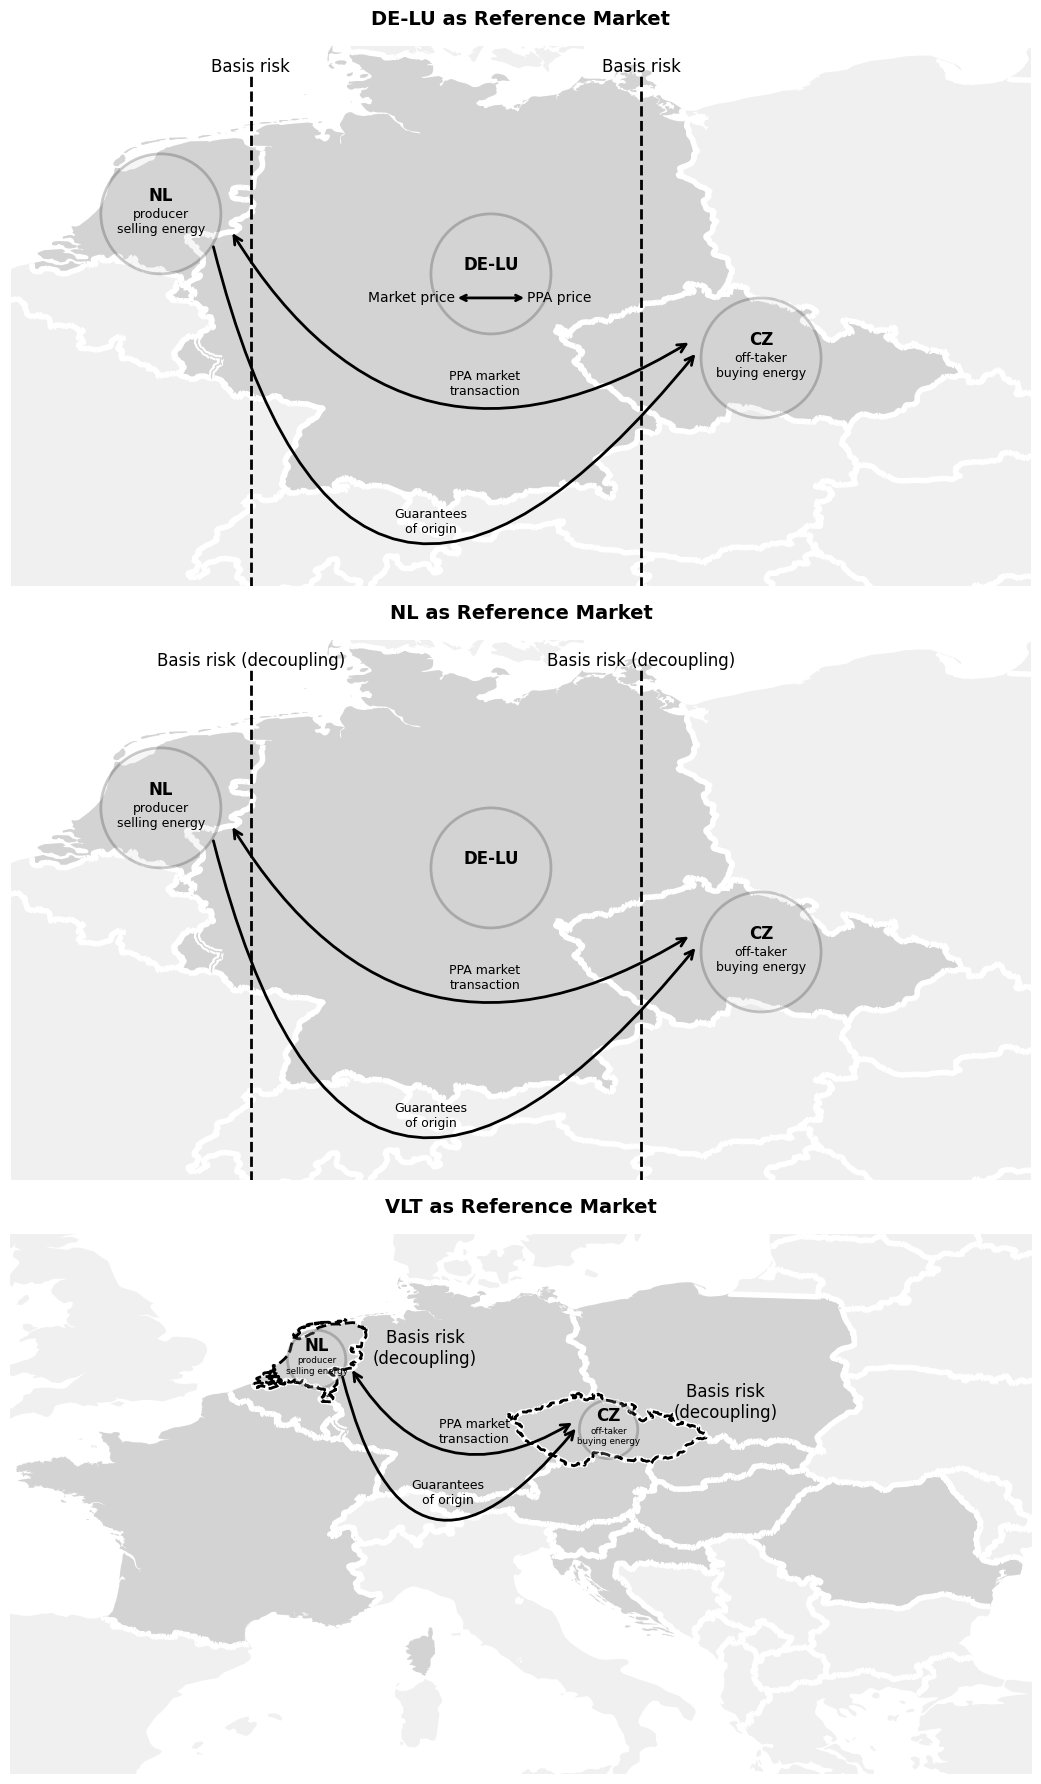

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# — Common styling —
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

# Approximate lon/lat positions for NL, DE, CZ
positions = {
    'NL': (5.5, 52.2),
    'DE': (11.0, 51.2),
    'CZ': (15.5, 49.8),
}

# Core countries to shade in panel 3
acer_core = [
    'Austria','Belgium','Croatia','Czech Republic','France','Germany',
    'Hungary','Luxembourg','Netherlands','Poland','Romania','Slovakia','Slovenia'
]

# Countries to shade in panels 1 & 2
focus_names = ['Netherlands', 'Germany', 'Luxembourg', 'Czech Republic']

reader = shpreader.Reader(
    shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
)

# geometries for the small focus set
geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in focus_names
}

# geometries for the ACER CORE set
core_geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in acer_core
}

def shade_focus(ax):
    """Shade the four focus countries."""
    for geom in geoms.values():
        ax.add_geometries(
            [geom],
            ccrs.PlateCarree(),
            facecolor='#d3d3d3',
            edgecolor='none',
            zorder=0
        )

fig = plt.figure(figsize=(14, 18))

panels = [
    ("DE-LU as Reference Market", ['NL','DE','CZ']),
    ("NL as Reference Market",    ['NL','DE','CZ']),
    ("VLT as Reference Market",   ['NL','DE','CZ']),  # zoomed & core-shaded
]

for i, (title, circles) in enumerate(panels, start=1):
    ax = fig.add_subplot(3, 1, i, projection=ccrs.PlateCarree())

    # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.set_extent([3, 20, 46, 55], ccrs.PlateCarree())
    else:
        ax.set_extent([-5, 30, 38, 56.5], ccrs.PlateCarree())

    # land background
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', zorder=0)

    # shading logic
    if i < 3:
        shade_focus(ax)
    else:
        # shade the original four _and_ all ACER CORE countries
        shade_focus(ax)
        for geom in core_geoms.values():
            ax.add_geometries(
                [geom],
                ccrs.PlateCarree(),
                facecolor='#d3d3d3',
                edgecolor='none',
                zorder=0
            )

    # white borders
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_boundary_lines_land', '10m',
            edgecolor='white', facecolor='none', linewidth=4
        ),
        zorder=1
    )

    # dashed LUX–DE border (all panels)
    lux = geoms['Luxembourg']
    de_geom = geoms['Germany']
    lux_de = lux.boundary.intersection(de_geom.boundary)
    ax.add_geometries([lux_de], ccrs.PlateCarree(),
                      edgecolor='lightgray', facecolor='none',
                      linestyle='--', linewidth=1, zorder=2)

    # basis-risk: verticals in panels 1&2, border outlines in panel 3
    if i < 3:
        border_x = [7.0, 13.5]
        labels = (["Basis risk", "Basis risk"] if i == 1
                  else ["Basis risk (decoupling)"]*2)
        for x, txt in zip(border_x, labels):
            ax.plot([x, x], [45, 54.5],
                    linestyle='--', linewidth=2, color='black',
                    transform=ccrs.PlateCarree(), zorder=2)
            ax.text(x, 54.5, txt, ha='center', va='bottom',
                    transform=ccrs.PlateCarree(), zorder=3)
    else:
        cz = geoms['Czech Republic']
        nl = geoms['Netherlands']
        for geom in (cz.boundary, nl.boundary):
            ax.add_geometries(
                [geom], ccrs.PlateCarree(),
                edgecolor='black', facecolor='none',
                linestyle='--', linewidth=2, zorder=2
            )
        for name, geom in (('CZ', cz), ('NL', nl)):
            c = geom.centroid
            dx = 4.2 if name == 'CZ' else 4
            dy = 1 if name == 'CZ' else 0.5
            ax.text(c.x + dx, c.y+dy, "Basis risk\n(decoupling)",
                    ha='center', va='center',
                    transform=ccrs.PlateCarree(), zorder=3)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15, zorder=4)
    ax.axis('off')

    # circles (skip DE in panel 3)
    for key in circles:
        if i == 3 and key == 'DE':
            continue
        lon, lat = positions[key]
        ax.add_patch(Circle(
            (lon, lat), 1.0,
            edgecolor='black', linewidth=2,
            facecolor='lightgrey', alpha=0.2,
            transform=ccrs.PlateCarree(), zorder=5
        ))

    # country labels & subtitles
    if i < 3:
      subsize=1
    else:
      subsize=0.7

    if 'NL' in circles:
        x, y = positions['NL']
        ax.text(x, y + 0.15, "NL", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "producer\nselling energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)
    if 'DE' in circles and not (i == 3):
        x, y = positions['DE']
        ax.text(x, y + 0.15, "DE-LU", ha='center', va='center',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
    if 'CZ' in circles:
        x, y = positions['CZ']
        ax.text(x, y + 0.15, "CZ", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "off-taker\nbuying energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)

    # two-headed DE arrow (panel 1 only)
    if i == 1:
        x0, y0 = positions['DE']
        y0 -= 0.4
        ax.annotate(
            "", xy=(x0 + 0.6, y0), xytext=(x0 - 0.6, y0),
            arrowprops=dict(arrowstyle='<->', mutation_scale=10,
                            linewidth=2, color='black'),
            transform=ccrs.PlateCarree(), zorder=6
        )
        ax.text(x0 - 0.6, y0, "Market price",
                ha='right', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x0 + 0.6, y0, "PPA price",
                ha='left', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)

    # concentric arrows & labels (all panels)
    start, end = positions['NL'], positions['CZ']
    dx, dy = end[0] - start[0], end[1] - start[1]
    dist = math.hypot(dx, dy)
    r_inner, r_outer = 1.2, 1.3
    start_i = (start[0] + dx*r_inner/dist, start[1] + dy*r_inner/dist)
    end_i   = (end[0]   - dx*r_inner/dist, end[1]   - dy*r_inner/dist)
    start_o = (start[0] + dx*r_outer/dist - 0.4,
               start[1] + dy*r_outer/dist - 0.2)
    end_o   = (end[0]   - dx*r_outer/dist + 0.2,
               end[1]   - dy*r_outer/dist - 0.2)

    inner = FancyArrowPatch(
        posA=start_i, posB=end_i,
        connectionstyle="arc3,rad=0.5",
        arrowstyle='<->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
    ax.add_patch(inner)
    outer = FancyArrowPatch(
        posA=start_o, posB=end_o,
        connectionstyle="arc3,rad=1.0",
        arrowstyle='->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
        # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 1.4, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 3.4, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
    else:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 0.8, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 2.6, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)

plt.tight_layout()
plt.show()


c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\marek\OneDrive\git-personal\ACER-CORE-Virtual-Hub-Simulation\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


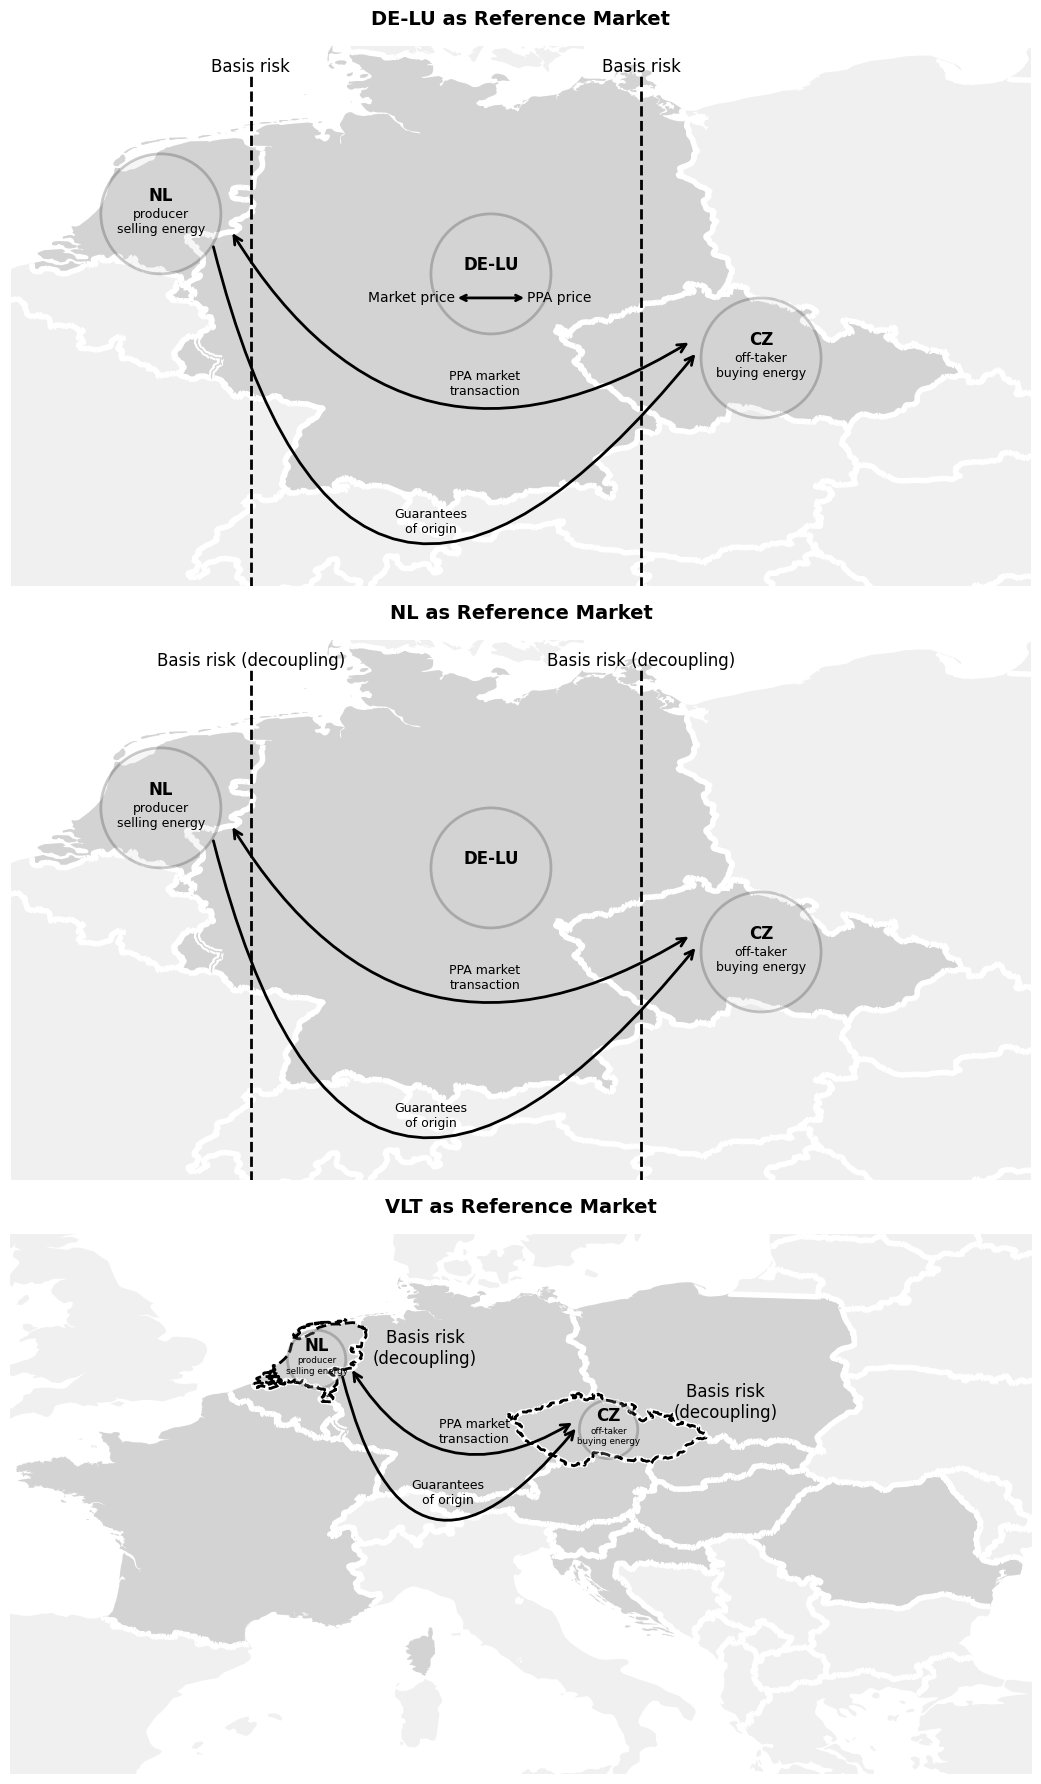

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# — Common styling —
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

# Approximate lon/lat positions for NL, DE, CZ
positions = {
    'NL': (5.5, 52.2),
    'DE': (11.0, 51.2),
    'CZ': (15.5, 49.8),
}

# Core countries to shade in panel 3
acer_core = [
    'Austria','Belgium','Croatia','Czech Republic','France','Germany',
    'Hungary','Luxembourg','Netherlands','Poland','Romania','Slovakia','Slovenia'
]

# Countries to shade in panels 1 & 2
focus_names = ['Netherlands', 'Germany', 'Luxembourg', 'Czech Republic']

reader = shpreader.Reader(
    shpreader.natural_earth('10m', 'cultural', 'admin_0_countries')
)

# geometries for the small focus set
geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in focus_names
}

# geometries for the ACER CORE set
core_geoms = {
    rec.attributes['NAME_LONG']: rec.geometry
    for rec in reader.records()
    if rec.attributes['NAME_LONG'] in acer_core
}

def shade_focus(ax):
    """Shade the four focus countries."""
    for geom in geoms.values():
        ax.add_geometries(
            [geom],
            ccrs.PlateCarree(),
            facecolor='#d3d3d3',
            edgecolor='none',
            zorder=0
        )

fig = plt.figure(figsize=(14, 18))

panels = [
    ("DE-LU as Reference Market", ['NL','DE','CZ']),
    ("NL as Reference Market",    ['NL','DE','CZ']),
    ("VLT as Reference Market",   ['NL','DE','CZ']),  # zoomed & core-shaded
]

for i, (title, circles) in enumerate(panels, start=1):
    ax = fig.add_subplot(3, 1, i, projection=ccrs.PlateCarree())

    # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.set_extent([3, 20, 46, 55], ccrs.PlateCarree())
    else:
        ax.set_extent([-5, 30, 38, 56.5], ccrs.PlateCarree())

    # land background
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', zorder=0)

    # shading logic
    if i < 3:
        shade_focus(ax)
    else:
        # shade the original four _and_ all ACER CORE countries
        shade_focus(ax)
        for geom in core_geoms.values():
            ax.add_geometries(
                [geom],
                ccrs.PlateCarree(),
                facecolor='#d3d3d3',
                edgecolor='none',
                zorder=0
            )

    # white borders
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_boundary_lines_land', '10m',
            edgecolor='white', facecolor='none', linewidth=4
        ),
        zorder=1
    )

    # dashed LUX–DE border (all panels)
    lux = geoms['Luxembourg']
    de_geom = geoms['Germany']
    lux_de = lux.boundary.intersection(de_geom.boundary)
    ax.add_geometries([lux_de], ccrs.PlateCarree(),
                      edgecolor='lightgray', facecolor='none',
                      linestyle='--', linewidth=1, zorder=2)

    # basis-risk: verticals in panels 1&2, border outlines in panel 3
    if i < 3:
        border_x = [7.0, 13.5]
        labels = (["Basis risk", "Basis risk"] if i == 1
                  else ["Basis risk (decoupling)"]*2)
        for x, txt in zip(border_x, labels):
            ax.plot([x, x], [45, 54.5],
                    linestyle='--', linewidth=2, color='black',
                    transform=ccrs.PlateCarree(), zorder=2)
            ax.text(x, 54.5, txt, ha='center', va='bottom',
                    transform=ccrs.PlateCarree(), zorder=3)
    else:
        cz = geoms['Czech Republic']
        nl = geoms['Netherlands']
        for geom in (cz.boundary, nl.boundary):
            ax.add_geometries(
                [geom], ccrs.PlateCarree(),
                edgecolor='black', facecolor='none',
                linestyle='--', linewidth=2, zorder=2
            )
        for name, geom in (('CZ', cz), ('NL', nl)):
            c = geom.centroid
            dx = 4.2 if name == 'CZ' else 4
            dy = 1 if name == 'CZ' else 0.5
            ax.text(c.x + dx, c.y+dy, "Basis risk\n(decoupling)",
                    ha='center', va='center',
                    transform=ccrs.PlateCarree(), zorder=3)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15, zorder=4)
    ax.axis('off')

    # circles (skip DE in panel 3)
    for key in circles:
        if i == 3 and key == 'DE':
            continue
        lon, lat = positions[key]
        ax.add_patch(Circle(
            (lon, lat), 1.0,
            edgecolor='black', linewidth=2,
            facecolor='lightgrey', alpha=0.2,
            transform=ccrs.PlateCarree(), zorder=5
        ))

    # country labels & subtitles
    if i < 3:
      subsize=1
    else:
      subsize=0.7

    if 'NL' in circles:
        x, y = positions['NL']
        ax.text(x, y + 0.15, "NL", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "producer\nselling energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)
    if 'DE' in circles and not (i == 3):
        x, y = positions['DE']
        ax.text(x, y + 0.15, "DE-LU", ha='center', va='center',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
    if 'CZ' in circles:
        x, y = positions['CZ']
        ax.text(x, y + 0.15, "CZ", ha='center', va='bottom',
                fontweight='bold', transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x, y + 0.1, "off-taker\nbuying energy",
                ha='center', va='top', fontsize=9*subsize,
                transform=ccrs.PlateCarree(), zorder=6)

    # two-headed DE arrow (panel 1 only)
    if i == 1:
        x0, y0 = positions['DE']
        y0 -= 0.4
        ax.annotate(
            "", xy=(x0 + 0.6, y0), xytext=(x0 - 0.6, y0),
            arrowprops=dict(arrowstyle='<->', mutation_scale=10,
                            linewidth=2, color='black'),
            transform=ccrs.PlateCarree(), zorder=6
        )
        ax.text(x0 - 0.6, y0, "Market price",
                ha='right', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)
        ax.text(x0 + 0.6, y0, "PPA price",
                ha='left', va='center', fontsize=10,
                transform=ccrs.PlateCarree(), zorder=6)

    # concentric arrows & labels (all panels)
    start, end = positions['NL'], positions['CZ']
    dx, dy = end[0] - start[0], end[1] - start[1]
    dist = math.hypot(dx, dy)
    r_inner, r_outer = 1.2, 1.3
    start_i = (start[0] + dx*r_inner/dist, start[1] + dy*r_inner/dist)
    end_i   = (end[0]   - dx*r_inner/dist, end[1]   - dy*r_inner/dist)
    start_o = (start[0] + dx*r_outer/dist - 0.4,
               start[1] + dy*r_outer/dist - 0.2)
    end_o   = (end[0]   - dx*r_outer/dist + 0.2,
               end[1]   - dy*r_outer/dist - 0.2)

    inner = FancyArrowPatch(
        posA=start_i, posB=end_i,
        connectionstyle="arc3,rad=0.5",
        arrowstyle='<->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
    ax.add_patch(inner)
    outer = FancyArrowPatch(
        posA=start_o, posB=end_o,
        connectionstyle="arc3,rad=1.0",
        arrowstyle='->', mutation_scale=15,
        linewidth=2, color='black',
        transform=ccrs.PlateCarree(), zorder=6
    )
        # original extent for panels 1 & 2, larger for panel 3
    if i < 3:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 1.4, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 3.4, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
    else:
        ax.add_patch(outer)
        mx_i, my_i = (start_i[0] + end_i[0]) / 2, (start_i[1] + end_i[1]) / 2
        ax.text(mx_i + 0.4, my_i - 0.8, "PPA market\ntransaction",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)
        mx_o, my_o = (start_o[0] + end_o[0]) / 2 - 0.4, (start_o[1] + end_o[1]) / 2 - 0.1
        ax.text(mx_o, my_o - 2.6, "Guarantees\nof origin",
                ha='center', va='top', fontsize=9,
                transform=ccrs.PlateCarree(), zorder=6)

plt.tight_layout()
plt.show()
